##Social network Graph Link Prediction - Facebook Challenge with
##Preferential Attachment and svd_dot features

###1. Import all libraries

In [ ]:
import networkx as nx
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import HDFStore,read_hdf,DataFrame
from google.colab import drive
drive.mount('/content/drive/')
from scipy.sparse.linalg import svds
from scipy.stats import randint, uniform
import pickle
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

Mounted at /content/drive/


###2. Pre-processing data

####2.1. Import the pre-processed data

In [ ]:
df_final_train = read_hdf('/content/drive/My Drive/Applied AI Course/Assignments/Assignment 17/storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf('/content/drive/My Drive/Applied AI Course/Assignments/Assignment 17/storage_sample_stage4.h5', 'test_df',mode='r')

####2.2 Generate Preferential Attachment feature data and save to HDF file

In [ ]:
# This function take source and destination nodes and return the preferential attachment values
def get_pref_attach(df_edges,col_name):
  # create a new graph from the given edge list
  g = nx.from_pandas_edgelist(df_edges,source='source_node',target='destination_node',create_using=nx.DiGraph())
  # calculate preferential attachment percentages
  pref_attach = np.array([degree for node,degree in g.degree()]) / sum(dict(g.degree()).values())
  node_list = [node for node,degree in g.degree()]
  return [pref_attach[node_list.index(i)] for i in df_edges[col_name]]

In [ ]:
if not os.path.isfile('/content/drive/My Drive/Applied AI Course/Assignments/Assignment 17/data/fea_sample/storage_sample_stage5.h5'):
    df_final_train['pref_attach_followers'] = get_pref_attach(df_final_train[['source_node','destination_node']],'source_node')
    df_final_train['pref_attach_followees'] = get_pref_attach(df_final_train[['source_node','destination_node']],'destination_node')
    df_final_test['pref_attach_followers'] = get_pref_attach(df_final_test[['source_node','destination_node']],'source_node')
    df_final_test['pref_attach_followees'] = get_pref_attach(df_final_test[['source_node','destination_node']],'destination_node')

    hdf = HDFStore('/content/drive/My Drive/Applied AI Course/Assignments/Assignment 17/data/fea_sample/storage_sample_stage5.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('/content/drive/My Drive/Applied AI Course/Assignments/Assignment 17/data/fea_sample/storage_sample_stage5.h5', 'train_df',mode='r')
    df_final_test = read_hdf('/content/drive/My Drive/Applied AI Course/Assignments/Assignment 17/data/fea_sample/storage_sample_stage5.h5', 'test_df',mode='r')

####2.3. Generate svd_dot feature data and save to HDF file

In [ ]:
if not os.path.isfile('/content/drive/My Drive/Applied AI Course/Assignments/Assignment 17/data/fea_sample/storage_sample_stage6.h5'):
    # calculating dot product between each of the 6 source and destination SVD values for all the left and right singular vectors
    df_final_train['svd_dot_u_1'] = df_final_train.apply(lambda row: np.dot(row[['svd_u_s_1']], row[['svd_u_d_1']]), axis=1)
    df_final_train['svd_dot_u_2'] = df_final_train.apply(lambda row: np.dot(row[['svd_u_s_2']], row[['svd_u_d_2']]), axis=1)
    df_final_train['svd_dot_u_3'] = df_final_train.apply(lambda row: np.dot(row[['svd_u_s_3']], row[['svd_u_d_3']]), axis=1)
    df_final_train['svd_dot_u_4'] = df_final_train.apply(lambda row: np.dot(row[['svd_u_s_4']], row[['svd_u_d_4']]), axis=1)
    df_final_train['svd_dot_u_5'] = df_final_train.apply(lambda row: np.dot(row[['svd_u_s_5']], row[['svd_u_d_5']]), axis=1)
    df_final_train['svd_dot_u_6'] = df_final_train.apply(lambda row: np.dot(row[['svd_u_s_6']], row[['svd_u_d_6']]), axis=1)
    df_final_train['svd_dot_v_1'] = df_final_train.apply(lambda row: np.dot(row[['svd_v_s_1']], row[['svd_v_d_1']]), axis=1)
    df_final_train['svd_dot_v_2'] = df_final_train.apply(lambda row: np.dot(row[['svd_v_s_2']], row[['svd_v_d_2']]), axis=1)
    df_final_train['svd_dot_v_3'] = df_final_train.apply(lambda row: np.dot(row[['svd_v_s_3']], row[['svd_v_d_3']]), axis=1)
    df_final_train['svd_dot_v_4'] = df_final_train.apply(lambda row: np.dot(row[['svd_v_s_4']], row[['svd_v_d_4']]), axis=1)
    df_final_train['svd_dot_v_5'] = df_final_train.apply(lambda row: np.dot(row[['svd_v_s_5']], row[['svd_v_d_5']]), axis=1)
    df_final_train['svd_dot_v_6'] = df_final_train.apply(lambda row: np.dot(row[['svd_v_s_6']], row[['svd_v_d_6']]), axis=1)

    df_final_test['svd_dot_u_1'] = df_final_test.apply(lambda row: np.dot(row[['svd_u_s_1']], row[['svd_u_d_1']]), axis=1)
    df_final_test['svd_dot_u_2'] = df_final_test.apply(lambda row: np.dot(row[['svd_u_s_2']], row[['svd_u_d_2']]), axis=1)
    df_final_test['svd_dot_u_3'] = df_final_test.apply(lambda row: np.dot(row[['svd_u_s_3']], row[['svd_u_d_3']]), axis=1)
    df_final_test['svd_dot_u_4'] = df_final_test.apply(lambda row: np.dot(row[['svd_u_s_4']], row[['svd_u_d_4']]), axis=1)
    df_final_test['svd_dot_u_5'] = df_final_test.apply(lambda row: np.dot(row[['svd_u_s_5']], row[['svd_u_d_5']]), axis=1)
    df_final_test['svd_dot_u_6'] = df_final_test.apply(lambda row: np.dot(row[['svd_u_s_6']], row[['svd_u_d_6']]), axis=1)
    df_final_test['svd_dot_v_1'] = df_final_test.apply(lambda row: np.dot(row[['svd_v_s_1']], row[['svd_v_d_1']]), axis=1)
    df_final_test['svd_dot_v_2'] = df_final_test.apply(lambda row: np.dot(row[['svd_v_s_2']], row[['svd_v_d_2']]), axis=1)
    df_final_test['svd_dot_v_3'] = df_final_test.apply(lambda row: np.dot(row[['svd_v_s_3']], row[['svd_v_d_3']]), axis=1)
    df_final_test['svd_dot_v_4'] = df_final_test.apply(lambda row: np.dot(row[['svd_v_s_4']], row[['svd_v_d_4']]), axis=1)
    df_final_test['svd_dot_v_5'] = df_final_test.apply(lambda row: np.dot(row[['svd_v_s_5']], row[['svd_v_d_5']]), axis=1)
    df_final_test['svd_dot_v_6'] = df_final_test.apply(lambda row: np.dot(row[['svd_v_s_6']], row[['svd_v_d_6']]), axis=1)

    hdf = HDFStore('/content/drive/My Drive/Applied AI Course/Assignments/Assignment 17/data/fea_sample/storage_sample_stage6.h5')
    hdf.put('train_df',df_final_train, format='table', data_columns=True)
    hdf.put('test_df',df_final_test, format='table', data_columns=True)
    hdf.close()
else:
    df_final_train = read_hdf('/content/drive/My Drive/Applied AI Course/Assignments/Assignment 17/data/fea_sample/storage_sample_stage6.h5', 'train_df',mode='r')
    df_final_test = read_hdf('/content/drive/My Drive/Applied AI Course/Assignments/Assignment 17/data/fea_sample/storage_sample_stage6.h5', 'test_df',mode='r')

####2.4. Split the data for train and test

In [ ]:
y_train = df_final_train['indicator_link']
y_test = df_final_train['indicator_link']
df_final_train.drop(['source_node','destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node','destination_node','indicator_link'],axis=1,inplace=True)
X_train, X_test, y_train, y_test = train_test_split(df_final_train, y_train, test_size=0.2)

###3. Modeling

####3.1. Modeling and Hyperparameter tuning

In [ ]:
# Set "objective" to "binary:logistic" as we are posing this problem as a binary classification problem
model = xgb.XGBClassifier(objective='binary:logistic')
# parameters are generating randomly by "scipy" functions
param_dist = {
              'n_estimators': randint(10, 500),
              'max_depth': randint(3, 10),
              'learning_rate': uniform(0.01, 0.5),
              'gamma': uniform(0, 1)
             }
# Random search cross validation is doing 5 iterations and 5 cross validations (based on the available system configuration)
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=5, cv=5, verbose=2)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
cv_results = random_search.cv_results_

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END gamma=0.42346284373104925, learning_rate=0.16152996193518537, max_depth=8, n_estimators=470; total time= 6.4min
[CV] END gamma=0.42346284373104925, learning_rate=0.16152996193518537, max_depth=8, n_estimators=470; total time= 6.4min
[CV] END gamma=0.42346284373104925, learning_rate=0.16152996193518537, max_depth=8, n_estimators=470; total time= 6.3min
[CV] END gamma=0.42346284373104925, learning_rate=0.16152996193518537, max_depth=8, n_estimators=470; total time= 6.0min
[CV] END gamma=0.42346284373104925, learning_rate=0.16152996193518537, max_depth=8, n_estimators=470; total time= 6.4min
[CV] END gamma=0.5392746456356617, learning_rate=0.38959284070130973, max_depth=7, n_estimators=431; total time= 4.6min
[CV] END gamma=0.5392746456356617, learning_rate=0.38959284070130973, max_depth=7, n_estimators=431; total time= 4.5min
[CV] END gamma=0.5392746456356617, learning_rate=0.38959284070130973, max_depth=7, n_estimators

####3.2. Best parameters

In [ ]:
params = best_model.get_params()
params_non_none = {k: v for k, v in params.items() if v is not None}
print(params_non_none)

{'objective': 'binary:logistic', 'enable_categorical': False, 'gamma': 0.3851949359412996, 'learning_rate': 0.46044307995151457, 'max_depth': 7, 'missing': nan, 'n_estimators': 381}


####3.3. Save model parameters to a pickle file

In [ ]:
if not os.path.isfile('/content/drive/My Drive/Applied AI Course/Assignments/Assignment 17/data/xbg_best_model.pkl'):
    with open('/content/drive/My Drive/Applied AI Course/Assignments/Assignment 17/data/xbg_best_model.pkl', 'wb') as f:
      pickle.dump(best_model, f)
else:
    with open('/content/drive/My Drive/Applied AI Course/Assignments/Assignment 17/data/xbg_best_model.pkl', 'rb') as f:
      best_model = pickle.load(f)
if not os.path.isfile('/content/drive/My Drive/Applied AI Course/Assignments/Assignment 17/data/xbg_cv_results.pkl'):
    with open('/content/drive/My Drive/Applied AI Course/Assignments/Assignment 17/data/xbg_cv_results.pkl', 'wb') as f:
      pickle.dump(cv_results, f)
else:
    with open('/content/drive/My Drive/Applied AI Course/Assignments/Assignment 17/data/xbg_cv_results.pkl', 'rb') as f:
      cv_results = pickle.load(f)

###4. Performance analysis

####4.1 Cross Validation results

In [ ]:
gamma = [value for params in cv_results['params'] for item, value in params.items() if item=='gamma']
learning_rate = [value for params in cv_results['params'] for item, value in params.items() if item=='learning_rate']
max_depth = [value for params in cv_results['params'] for item, value in params.items() if item=='max_depth']
n_estimators = [value for params in cv_results['params'] for item, value in params.items() if item=='n_estimators']

In [ ]:
from prettytable import PrettyTable
table = PrettyTable()
table.add_column('test score rank',cv_results['rank_test_score'])
table.add_column("Test score", cv_results['mean_test_score'])
table.add_column("gamma", gamma)
table.add_column("learning rate", learning_rate)
table.add_column("max depth", max_depth)
table.add_column("# of trees", n_estimators)
table.sortby = "test score rank"
print(table)

+-----------------+--------------------+---------------------+---------------------+-----------+------------+
| test score rank |     Test score     |        gamma        |    learning rate    | max depth | # of trees |
+-----------------+--------------------+---------------------+---------------------+-----------+------------+
|        1        | 0.982287736703956  | 0.03755482384517905 | 0.30862830286758763 |     7     |    429     |
|        2        | 0.9816127288919443 |  0.4762406811887633 |  0.3067256260666412 |     7     |    436     |
|        3        | 0.9814127554527842 | 0.42346284373104925 | 0.16152996193518537 |     8     |    470     |
|        4        | 0.9811627515467783 | 0.25346231521161555 | 0.21545532878036072 |     5     |    217     |
|        5        | 0.9808377390475596 |  0.5392746456356617 | 0.38959284070130973 |     7     |    431     |
+-----------------+--------------------+---------------------+---------------------+-----------+------------+


####Cross Validation summary:
- We got the best performance of the model with the score 98.23% when the "gamma" was least, at 0.038 and the number of trees was high (429).
- The model performance is less when the number of trees is in the range of 200.
- The model performance is least for a high gamma of 0.54.
- Neither the test score nor the parameters have high variation.

####4.2. F1 score

In [ ]:
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9959529341227609
Test f1 score 0.9961920032067342


####4.3. Confusion matrix

In [ ]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)

    A =(((C.T)/(C.sum(axis=1))).T)

    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))

    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")

    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")

    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")

    plt.show()

Train confusion_matrix


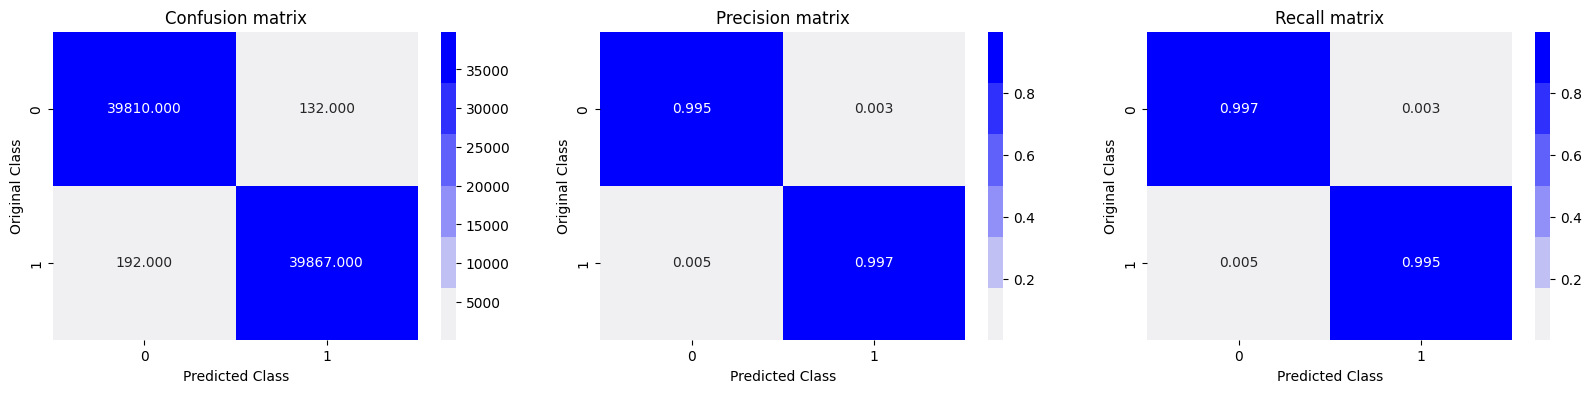

Test confusion_matrix


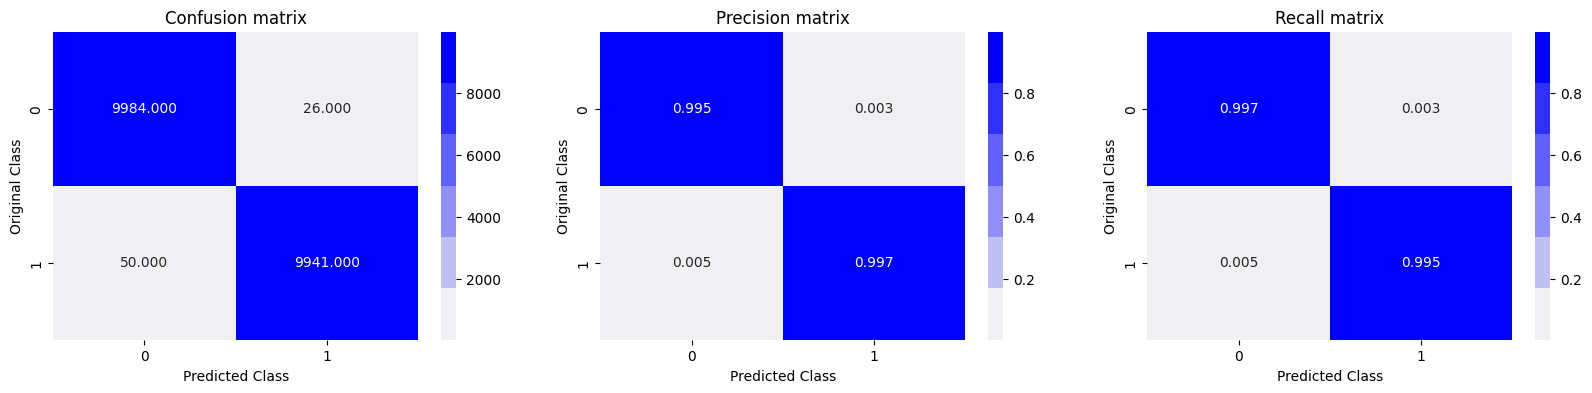

In [ ]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

####4.4. ROC curve

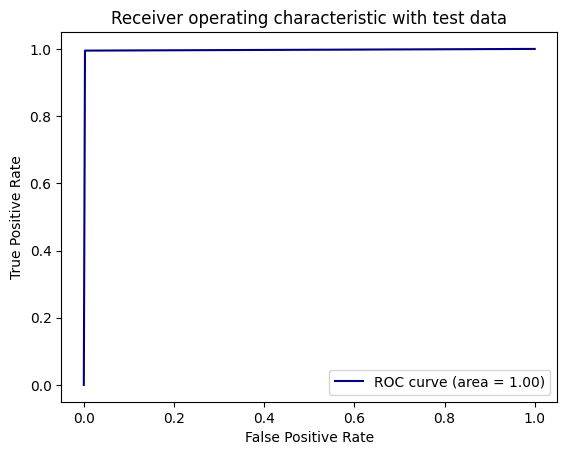

In [ ]:
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

###5. Conclusion

- The model performance has been improved. The test F1 score is improved from 92% to 99.62%